In [1]:
import os, json
import pandas as pd

# this finds our json files
path_to_json = '../CORD/train/json/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data = pd.DataFrame(columns=['validline'])

f = open("receipt_words.csv", "w")
print("filename",",","index",",","x1",",",'x2',",",'x3',",",'x4',",",'y1',",",'y2',",",'y3',",",'y4',",",'is_key',",",'row_id',",",'text',",",'category',",","group_id",file=f)


# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        
       # print(json_text)

        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        lines = json_text['valid_line']
        
        for x in lines:
            words = x['words']
            category = x['category']
            group_id = x['group_id']
            for y in words:
                print(js,index,y['quad']['x1'],y['quad']['x2'],y['quad']['x3'],y['quad']['x4'],y['quad']['y1'],y['quad']['y2'],y['quad']['y3'],y['quad']['y4'],y['is_key'],y['row_id'],"\""+y['text']+"\"",category,group_id,file=f,sep=",")

       # city = json_text['features'][0]['properties']['name']
        #lonlat = json_text['features'][0]['geometry']['coordinates']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        #f.close()
        #jsons_data.loc[index] = [words, city, lonlat]

# now that we have the pertinent json data in our DataFrame let's look at it
f.close()

In [2]:
import pandas as pd
receipts_df = pd.read_csv("receipt_words.csv")
receipts_df.columns = receipts_df.columns.str.strip()
receipts_df['text'] = receipts_df['text'].str.strip()


In [3]:
receipts_df.dtypes

filename    object
index        int64
x1           int64
x2           int64
x3           int64
x4           int64
y1           int64
y2           int64
y3           int64
y4           int64
is_key       int64
row_id       int64
text        object
category    object
group_id     int64
dtype: object

In [4]:
char2idx = {"START":0,"END":1,"a":2,"b":3,"c":4,"d":5,"e":6,"f":7,"g":8,"h":9,"i":10,"j":11,"k":12,"l":13,"m":14,"n":15,"o":16,"p":17,"q":18,"r":19,"s":20,"t":21,"u":22,"v":23,"w":24,"x":25,"y":26,"z":27,"0":28,"1":29,"2":30,"3":31,"4":32,"5":33,"6":34,"7":35,"8":36,"9":37,".":38,"-":39,",":40,":":41," ":42}

In [5]:
#p_test.SentimentText=p_test.SentimentText.astype(str)
receipts_df.text = receipts_df.text.astype(str)
receipts_df.dtypes

filename    object
index        int64
x1           int64
x2           int64
x3           int64
x4           int64
y1           int64
y2           int64
y3           int64
y4           int64
is_key       int64
row_id       int64
text        object
category    object
group_id     int64
dtype: object

In [6]:
words = receipts_df['text']

In [7]:
indexed_words = []
j=43
for word in words:
    indexed_word = []
    #print(word)
    word = word.lower();
    for i in range(len(word)):
        token = word[i]
        if token not in char2idx:
            char2idx[token] = j
            j += 1
        indexed_word.append(char2idx[token])
    indexed_words.append(indexed_word)

receipts_df["indexed_words"] = indexed_words;

In [8]:
import numpy as np
def get_bigram_probs(words, V, start_idx, end_idx, smoothing=1):
  # structure of bigram probability matrix will be:
  # (last word, current word) --> probability
  # we will use add-1 smoothing
  # note: we'll always ignore this from the END token
  bigram_probs = np.ones((V, V)) * smoothing
  for word in words:
    for i in range(len(word)):
      
      if i == 0:
        # beginning word
        word[i]
        bigram_probs[start_idx, word[i]] += 1
      else:
        # middle word
        bigram_probs[word[i-1], word[i]] += 1

      # if we're at the final word
      # we update the bigram for last -> current
      # AND current -> END token
      if i == len(word) - 1:
        # final word
        bigram_probs[word[i], end_idx] += 1

  # normalize the counts along the rows to get probabilities
  bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
  return bigram_probs

In [9]:
start_idx = char2idx['START']
end_idx = char2idx['END']
V = len(char2idx)



In [10]:
bigram_probs = get_bigram_probs(indexed_words, V, start_idx, end_idx, smoothing=0.1)

In [11]:
bigram_probs

array([[5.27303790e-06, 5.27303790e-06, 1.57716564e-02, ...,
        1.10733796e-04, 5.80034169e-05, 1.10733796e-04],
       [1.56250000e-02, 1.56250000e-02, 1.56250000e-02, ...,
        1.56250000e-02, 1.56250000e-02, 1.56250000e-02],
       [1.57918009e-05, 7.97643863e-02, 8.05381846e-04, ...,
        1.57918009e-05, 1.57918009e-05, 1.57918009e-05],
       ...,
       [1.19047619e-02, 2.50000000e-01, 1.19047619e-02, ...,
        1.19047619e-02, 1.19047619e-02, 1.19047619e-02],
       [1.19047619e-02, 1.19047619e-02, 1.19047619e-02, ...,
        1.19047619e-02, 1.30952381e-01, 1.19047619e-02],
       [1.19047619e-02, 1.19047619e-02, 1.30952381e-01, ...,
        1.19047619e-02, 1.19047619e-02, 1.19047619e-02]])

In [12]:
 # a function to calculate normalized log prob score
  # for a sentence
def get_score(word):
    #print("word")
    #print(word)
    score = 0
    if len(word) > 0 :
        for i in range(len(word)):
          if i == 0:
            # beginning word
            score += np.log(bigram_probs[start_idx, word[i]])
          else:
            # middle word
            score += np.log(bigram_probs[word[i-1], word[i]])
        # final word
        score += np.log(bigram_probs[word[i-1], end_idx])

    # normalize the score
    # return score / (len(word) + 1)
    if score == 0:
        return score;
    else :
        return  ((-1)*(len(word) + 1)/score)*100

In [13]:
from future.utils import iteritems

idx2char = dict((v, k) for k, v in iteritems(char2idx))
def get_word(word):
    return ''.join(idx2char[i] for i in word)

In [14]:
receipts_df['text_score'] = receipts_df.apply(lambda row : get_score(row['indexed_words']), axis = 1)

In [15]:
receipts_df

,filename,index,x1,x2,x3,x4,y1,y2,y3,y4,is_key,row_id,text,category,group_id,indexed_words,text_score
0,receipt_00580.json,0,250,325,325,250,833,834,869,868,0,879802,Tebu,menu.nm,3,"[21, 6, 3, 22]",36.669749
1,receipt_00580.json,0,340,434,433,339,832,833,868,867,0,879802,Lemon,menu.nm,3,"[13, 6, 14, 16, 15]",35.199925
2,receipt_00580.json,0,217,227,228,217,835,834,869,869,0,879802,1,menu.cnt,3,[29],75.625303
3,receipt_00580.json,0,841,954,954,841,824,824,864,864,0,879802,22.000,menu.price,3,"[30, 30, 38, 28, 28, 28]",66.930682
4,receipt_00580.json,0,249,342,344,249,921,920,990,992,1,879803,Total,total.total_price,4,"[21, 16, 21, 2, 13]",62.899046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18953,receipt_00281.json,786,186,449,451,188,671,654,691,707,1,1623131,SUBTOTAL,sub_total.subtotal_price,10,"[20, 22, 3, 21, 16, 21, 2, 13]",61.298959
18954,receipt_00281.json,786,630,712,712,630,642,642,678,678,0,1623131,"9,500",sub_total.subtotal_price,10,"[37, 40, 33, 28, 28]",54.478680
18955,receipt_00281.json,786,188,242,242,188,714,714,750,750,1,1623132,TAX,sub_total.tax_price,10,"[21, 2, 25]",40.665969
18956,receipt_00281.json,786,258,310,310,258,708,708,744,744,1,1623132,10%,sub_total.tax_price,10,"[29, 28, 43]",43.846155


In [16]:
categories = receipts_df['category'] 
category2idx = {}
idx2category = {}
j=0;
for category in categories:
    if category not in category2idx:
        category2idx[category] = j
        idx2category[j] = category
        j+=1

category2idx

def get_index_for_category(category):
    return category2idx[category]


def get_category_for_index(index):
    return idx2category[index]
        

In [17]:
receipts_df['category_idx'] = receipts_df.apply(lambda row : get_index_for_category(row['category']), axis = 1)
category2idx

{'menu.nm': 0,
 'menu.cnt': 1,
 'menu.price': 2,
 'total.total_price': 3,
 'total.cashprice': 4,
 'total.menuqty_cnt': 5,
 'menu.unitprice': 6,
 'sub_total.subtotal_price': 7,
 'total.changeprice': 8,
 'total.emoneyprice': 9,
 'sub_total.tax_price': 10,
 'total.creditcardprice': 11,
 'menu.sub_nm': 12,
 'menu.sub_price': 13,
 'menu.discountprice': 14,
 'sub_total.discount_price': 15,
 'sub_total.service_price': 16,
 'total.menutype_cnt': 17,
 'total.total_etc': 18,
 'sub_total.etc': 19,
 'menu.sub_cnt': 20,
 'menu.sub_unitprice': 21,
 'menu.num': 22,
 'menu.vatyn': 23,
 'menu.sub_etc': 24,
 'menu.itemsubtotal': 25,
 'void_menu.nm': 26,
 'void_menu.price': 27,
 'menu.etc': 28,
 'sub_total.othersvc_price': 29}

In [18]:
data = receipts_df[['x1','x2','x3','x4','y1','y2','y3','y4','is_key','text_score','category_idx','index']]

#data = pd.to_numeric(receipts_df[['x1','x2','x3','x4','y1','y2','y3','y4','is_key','text_score','category_idx','index']])

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
#min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
print(x_scaled.shape)
X = pd.DataFrame(x_scaled,columns=['x1','x2','x3','x4','y1','y2','y3','y4','is_key','text_score','category_idx','index'])
X

(18958, 12)


,x1,x2,x3,x4,y1,y2,y3,y4,is_key,text_score,category_idx,index
0,0.112434,0.116948,0.116948,0.112434,0.205624,0.206701,0.208439,0.207184,0.0,0.253432,0.000000,0.0
1,0.152116,0.158742,0.158359,0.151675,0.205366,0.206443,0.208186,0.206931,0.0,0.234923,0.000000,0.0
2,0.097884,0.079371,0.079755,0.097884,0.206140,0.206701,0.208439,0.207437,0.0,0.743974,0.034483,0.0
3,0.373016,0.358129,0.358129,0.373016,0.203302,0.204124,0.207175,0.206173,0.0,0.634488,0.068966,0.0
4,0.111993,0.123466,0.124233,0.111993,0.228328,0.228866,0.239010,0.238553,1.0,0.583720,0.103448,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18953,0.084215,0.164494,0.165261,0.085097,0.163829,0.160309,0.163466,0.166456,1.0,0.563572,0.241379,1.0
18954,0.279982,0.265337,0.265337,0.279982,0.156347,0.157216,0.160182,0.159120,0.0,0.477688,0.241379,1.0
18955,0.085097,0.085123,0.085123,0.085097,0.174923,0.175773,0.178373,0.177334,1.0,0.303753,0.344828,1.0
18956,0.115961,0.111196,0.111196,0.115961,0.173375,0.174227,0.176857,0.175816,1.0,0.343799,0.344828,1.0


In [19]:


from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

def getcosine(X,Y):
    return cosine_similarity(X,Y)[0,0];

def getneighourscore(index,X):
    return X['text_score'].tolist()[0];

X["n1_cd"] = X.apply(lambda row : getcosine(X.loc[[row.name]],X.loc[[indices[row.name,1]]]), axis = 1)
print("n1_cd done")
X["n2_cd"] = X.apply(lambda row : getcosine(X.loc[[row.name]],X.loc[[indices[row.name,2]]]), axis = 1)
print("n2_cd done")
X["n3_cd"] = X.apply(lambda row : getcosine(X.loc[[row.name]],X.loc[[indices[row.name,3]]]), axis = 1)
print("n3_cd done")

X["n1_ed"] = X.apply(lambda row : distance.euclidean(X.loc[[row.name]],X.loc[[indices[row.name,1]]]), axis = 1)
print("n1_ed done")
X["n2_ed"] = X.apply(lambda row : distance.euclidean(X.loc[[row.name]],X.loc[[indices[row.name,2]]]), axis = 1)
print("n2_ed done")
X["n3_ed"] = X.apply(lambda row : distance.euclidean(X.loc[[row.name]],X.loc[[indices[row.name,3]]]), axis = 1)
print("n3_ed done")

X["n1_score"] = X.apply(lambda row : getneighourscore(row.name,X.loc[[indices[row.name,1]]]), axis = 1)
print("n1_score done")
X["n2_score"] = X.apply(lambda row : getneighourscore(row.name,X.loc[[indices[row.name,2]]]), axis = 1)
print("n2_score done")
X["n3_score"] = X.apply(lambda row : getneighourscore(row.name,X.loc[[indices[row.name,3]]]), axis = 1)
print("n3_score done")

X

n1_cd done
n2_cd done
n3_cd done
n1_ed done
n2_ed done
n3_ed done
n1_score done
n2_score done
n3_score done


,x1,x2,x3,x4,y1,y2,y3,y4,is_key,text_score,...,index,n1_cd,n2_cd,n3_cd,n1_ed,n2_ed,n3_ed,n1_score,n2_score,n3_score
0,0.112434,0.116948,0.116948,0.112434,0.205624,0.206701,0.208439,0.207184,0.0,0.253432,...,0.0,0.997451,0.998987,0.999390,0.043144,0.052755,0.056003,0.253473,0.297094,0.234624
1,0.152116,0.158742,0.158359,0.151675,0.205366,0.206443,0.208186,0.206931,0.0,0.234923,...,0.0,0.998740,0.999321,0.999450,0.029230,0.044424,0.053564,0.237905,0.196735,0.250273
2,0.097884,0.079371,0.079755,0.097884,0.206140,0.206701,0.208439,0.207437,0.0,0.743974,...,0.0,0.999445,0.999637,0.999470,0.029060,0.037173,0.057257,0.743974,0.743974,0.743974
3,0.373016,0.358129,0.358129,0.373016,0.203302,0.204124,0.207175,0.206173,0.0,0.634488,...,0.0,0.998387,0.999005,0.998765,0.066988,0.071586,0.091493,0.634488,0.658440,0.643475
4,0.111993,0.123466,0.124233,0.111993,0.228328,0.228866,0.239010,0.238553,1.0,0.583720,...,0.0,0.999010,0.999301,0.999288,0.058307,0.067445,0.076276,0.583720,0.592275,0.592275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18953,0.084215,0.164494,0.165261,0.085097,0.163829,0.160309,0.163466,0.166456,1.0,0.563572,...,1.0,0.999178,0.999099,0.999071,0.065435,0.087829,0.097517,0.563572,0.563572,0.563572
18954,0.279982,0.265337,0.265337,0.279982,0.156347,0.157216,0.160182,0.159120,0.0,0.477688,...,1.0,0.997339,0.996970,0.998250,0.095635,0.130351,0.129581,0.495295,0.482012,0.489560
18955,0.085097,0.085123,0.085123,0.085097,0.174923,0.175773,0.178373,0.177334,1.0,0.303753,...,1.0,0.999142,0.999304,0.999151,0.064324,0.070052,0.088395,0.311392,0.343799,0.337053
18956,0.115961,0.111196,0.111196,0.115961,0.173375,0.174227,0.176857,0.175816,1.0,0.343799,...,1.0,0.999293,0.999304,0.998935,0.058917,0.070052,0.101938,0.337053,0.303753,0.303753


In [20]:
receipts_df['category_idx'] 

0         0
1         0
2         1
3         2
4         3
         ..
18953     7
18954     7
18955    10
18956    10
18957    10
Name: category_idx, Length: 18958, dtype: int64

In [21]:
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers

In [22]:
X

,x1,x2,x3,x4,y1,y2,y3,y4,is_key,text_score,...,index,n1_cd,n2_cd,n3_cd,n1_ed,n2_ed,n3_ed,n1_score,n2_score,n3_score
0,0.112434,0.116948,0.116948,0.112434,0.205624,0.206701,0.208439,0.207184,0.0,0.253432,...,0.0,0.997451,0.998987,0.999390,0.043144,0.052755,0.056003,0.253473,0.297094,0.234624
1,0.152116,0.158742,0.158359,0.151675,0.205366,0.206443,0.208186,0.206931,0.0,0.234923,...,0.0,0.998740,0.999321,0.999450,0.029230,0.044424,0.053564,0.237905,0.196735,0.250273
2,0.097884,0.079371,0.079755,0.097884,0.206140,0.206701,0.208439,0.207437,0.0,0.743974,...,0.0,0.999445,0.999637,0.999470,0.029060,0.037173,0.057257,0.743974,0.743974,0.743974
3,0.373016,0.358129,0.358129,0.373016,0.203302,0.204124,0.207175,0.206173,0.0,0.634488,...,0.0,0.998387,0.999005,0.998765,0.066988,0.071586,0.091493,0.634488,0.658440,0.643475
4,0.111993,0.123466,0.124233,0.111993,0.228328,0.228866,0.239010,0.238553,1.0,0.583720,...,0.0,0.999010,0.999301,0.999288,0.058307,0.067445,0.076276,0.583720,0.592275,0.592275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18953,0.084215,0.164494,0.165261,0.085097,0.163829,0.160309,0.163466,0.166456,1.0,0.563572,...,1.0,0.999178,0.999099,0.999071,0.065435,0.087829,0.097517,0.563572,0.563572,0.563572
18954,0.279982,0.265337,0.265337,0.279982,0.156347,0.157216,0.160182,0.159120,0.0,0.477688,...,1.0,0.997339,0.996970,0.998250,0.095635,0.130351,0.129581,0.495295,0.482012,0.489560
18955,0.085097,0.085123,0.085123,0.085097,0.174923,0.175773,0.178373,0.177334,1.0,0.303753,...,1.0,0.999142,0.999304,0.999151,0.064324,0.070052,0.088395,0.311392,0.343799,0.337053
18956,0.115961,0.111196,0.111196,0.115961,0.173375,0.174227,0.176857,0.175816,1.0,0.343799,...,1.0,0.999293,0.999304,0.998935,0.058917,0.070052,0.101938,0.337053,0.303753,0.303753


In [23]:
X.shape

(18958, 21)

In [24]:
X.columns.values

array(['x1', 'x2', 'x3', 'x4', 'y1', 'y2', 'y3', 'y4', 'is_key',
       'text_score', 'category_idx', 'index', 'n1_cd', 'n2_cd', 'n3_cd',
       'n1_ed', 'n2_ed', 'n3_ed', 'n1_score', 'n2_score', 'n3_score'],
      dtype=object)

In [25]:
XX=X
XX['New_ID'] = range(0, 0+len(XX))
type(XX.columns.values)
cols = np.delete(XX.columns.values, np.where(XX.columns.values == 'New_ID'))
cols
Y=XX.groupby(['New_ID']).apply(lambda subdf : subdf[cols].values).reset_index()
Y[0]
Y[0].values
Z=Y[0].to_numpy()
Z.shape
Z[0]
A=np.stack(Z)
B=A.transpose(0,2,1)
B.shape

(18958, 21, 1)

In [26]:
A.shape

(18958, 1, 21)

In [27]:
B=A.transpose(0,2,1)

In [28]:
B.shape

(18958, 21, 1)

In [29]:
B

array([[[0.11243386],
        [0.11694785],
        [0.11694785],
        ...,
        [0.2534733 ],
        [0.29709446],
        [0.23462414]],

       [[0.1521164 ],
        [0.15874233],
        [0.1583589 ],
        ...,
        [0.23790455],
        [0.19673513],
        [0.25027328]],

       [[0.0978836 ],
        [0.07937117],
        [0.0797546 ],
        ...,
        [0.74397402],
        [0.74397402],
        [0.74397402]],

       ...,

       [[0.085097  ],
        [0.0851227 ],
        [0.0851227 ],
        ...,
        [0.31139214],
        [0.34379946],
        [0.33705287]],

       [[0.1159612 ],
        [0.11119632],
        [0.11119632],
        ...,
        [0.33705287],
        [0.30375341],
        [0.30375341]],

       [[0.29497354],
        [0.26687117],
        [0.26687117],
        ...,
        [0.25256083],
        [0.24297492],
        [0.27801372]]])

In [30]:

#data = receipts_df[['x1','x2','x3','x4','y1','y2','y3','y4','is_key','text_score','category_idx','index']]
data = X

data['category_idx']=receipts_df['category_idx'];

#from sklearn.neighbors import NearestNeighbors
#nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
#distances, indices = nbrs.kneighbors(data[0])


from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)
y = data.pop('category_idx')
X = data

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
x = X.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

X_train,X_test,y_train,y_test = train_test_split(X.index,y.index,test_size=0.2)
xtrain=X.iloc[X_train]
xtest=X.iloc[X_test]
y_train=y.iloc[y_train]
y_test=y.iloc[y_test]

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
print('Before Resampled dataset shape' )
print( y_train.shape)
sm = RandomOverSampler('all',random_state=42)
xtrain, y_train = sm.fit_resample(xtrain, y_train)
print(' Resampled dataset shape' )
print( y_train.shape)

ytrain = np.zeros((len(y_train), len(idx2category.values())))
ytest = np.zeros((len(y_test), len(idx2category.values())))
for i in range(len(y_train)):
    #print(y_train.values[i])
    ytrain[i][y_train[i]]=1
    
for i in range(len(y_test)):
    #print(y_train.values[i])
    ytrain[i][y_test.values[i]]=1



Using TensorFlow backend.


Before Resampled dataset shape
(15166,)
 Resampled dataset shape
(127110,)


In [31]:
type(xtrain)

numpy.ndarray

In [32]:
xtrain

array([[-0.59757191, -0.56325871, -0.5553561 , ...,  0.93754545,
         0.8027601 ,  1.23385094],
       [ 0.75243747,  0.69186352,  0.69127161, ...,  1.14159131,
         1.14627301, -1.03888331],
       [-0.87433921, -1.00818168, -1.00842565, ...,  1.76603739,
         1.77143362,  0.87095898],
       ...,
       [-0.35770692, -0.37924735, -0.37962004, ..., -0.31809008,
        -1.17689899,  1.63730787],
       [ 0.54947479,  0.44468409,  0.44414277, ..., -0.24700786,
        -0.73891944,  1.63712514],
       [-0.37000768, -0.38748667, -0.38785767, ..., -0.31809008,
        -1.17689899,  1.63675969]])

In [33]:
xtrain.shape

(127110, 21)

In [34]:
type(xtrain)

numpy.ndarray

In [36]:
XX=xtrain.copy()
XX=pd.DataFrame(xtrain.copy())
XX['New_ID'] = range(0, 0+len(XX))
type(XX.columns.values)
cols = np.delete(XX.columns.values, np.where(XX.columns.values == 'New_ID'))
Y=XX.groupby(['New_ID']).apply(lambda subdf : subdf[cols].values).reset_index()
print('groupby done')
Z=Y[0].to_numpy()
A=np.stack(Z)
print('restack done ...transposing')
B=A.transpose(0,2,1)
B.shape

groupby done
restack done ...transposing


(127110, 21, 1)

In [37]:
cnnModel = models.Sequential()
# Layer 1 = input layer
# specify the input size in the first layer.
#------------------------------------------
# Layer 1 = input layer
cnnModel.add(layers.Conv1D(32, 3, activation="relu", input_shape=B.shape[1:3] ))

cnnModel.add(layers.MaxPooling1D((2)))


# Layer 2
cnnModel.add(layers.Conv1D(64, 3, activation="relu"))

cnnModel.add(layers.MaxPooling1D((2)))


# Layer 3
cnnModel.add(layers.Conv1D(64, 3, activation="relu" ))

cnnModel.add(layers.Flatten())
#------------------------------------------

#dnnModel.add(layers.Dense(64, activation='elu', input_shape= (10,20,)))
cnnModel.add(layers.Dense(20, activation='relu'))

# Layer 2 = hidden layer 
#dnnModel.add(layers.Dense(60, activation='relu'))

# Layer 3 = hidden layer 
#dnnModel.add(layers.Dense(30, activation='linear'))

# Layer 4 = output layer
cnnModel.add(layers.Dense(len(category2idx), activation='softmax'))

cnnModel.summary()
cnnModel.compile( optimizer = 'adam', loss = 'cosine_similarity', metrics=['accuracy'] )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1

In [38]:

ytraintens=tf.convert_to_tensor(ytrain)

h  = cnnModel.fit( B, ytraintens, epochs=30, batch_size=32,validation_split=0.2)

Train on 101688 samples, validate on 25422 samples
Epoch 1/30
101688/101688 [==============================] - 21s 206us/sample - loss: -0.4986 - accuracy: 0.4221 - val_loss: -0.0013 - val_accuracy: 0.0013
Epoch 2/30
101688/101688 [==============================] - 19s 191us/sample - loss: -0.6022 - accuracy: 0.5462 - val_loss: -0.0013 - val_accuracy: 0.0013
Epoch 3/30
101688/101688 [==============================] - 194s 2ms/sample - loss: -0.6461 - accuracy: 0.5983 - val_loss: -0.0013 - val_accuracy: 0.0013
Epoch 4/30
101688/101688 [==============================] - 24s 237us/sample - loss: -0.6755 - accuracy: 0.6333 - val_loss: -0.0013 - val_accuracy: 0.0013
Epoch 5/30
101688/101688 [==============================] - 22s 219us/sample - loss: -0.6973 - accuracy: 0.6611 - val_loss: -0.0013 - val_accuracy: 0.0013
Epoch 6/30
101688/101688 [==============================] - 22s 218us/sample - loss: -0.7152 - accuracy: 0.6823 - val_loss: -0.0013 - val_accuracy: 0.0013
Epoch 7/30
101688/10

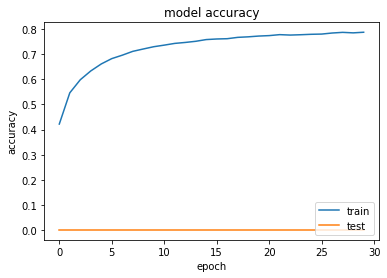

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
# visualise training history
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()